In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Dropout,
    LSTM, Dense
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import scipy.signal as signal
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Let's explore the WESAD dataset structure
import os

# Check the dataset structure
dataset_path = r'C:\Final Year\PROJECT\COGNITION\PREP\WESAD'
print("Dataset contents:")
for item in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, item)):
        print(f"📁 {item}/")
    else:
        print(f"📄 {item}")

# The WESAD dataset has subject folders (S2, S3, etc.)
subject_folders = [f for f in os.listdir(dataset_path) if f.startswith('S') and os.path.isdir(os.path.join(dataset_path, f))]
print(f"\nFound {len(subject_folders)} subject folders: {subject_folders}")

Dataset contents:
📁 S10/
📁 S11/
📁 S13/
📁 S14/
📁 S15/
📁 S16/
📁 S17/
📁 S2/
📁 S3/
📁 S4/
📁 S5/
📁 S6/
📁 S7/
📁 S8/
📁 S9/
📄 wesad_readme.pdf

Found 15 subject folders: ['S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']


In [3]:
# Let's examine one subject's data
sample_subject = 'S2'
sample_path = os.path.join(dataset_path, sample_subject)
print(f"\nContents of {sample_subject}:")
for item in os.listdir(sample_path):
    print(f"  {item}")


Contents of S2:
  S2.pkl
  S2_E4_Data
  S2_quest.csv
  S2_readme.txt
  S2_respiban.txt


In [5]:
def extract_features(ecg, eda, temp, resp, acc):
    """
    Extract features from physiological signals
    """
    features = []
    
    # ECG features
    features.extend([np.mean(ecg), np.std(ecg), np.min(ecg), np.max(ecg)])
    
    # Heart rate variability features
    try:
        # Use a more robust peak detection method
        peaks, _ = signal.find_peaks(ecg, height=np.mean(ecg) + 2*np.std(ecg), distance=100)
        if len(peaks) > 1:
            rr_intervals = np.diff(peaks) / 700  # Convert to seconds (ECG at 700Hz)
            features.extend([np.mean(rr_intervals), np.std(rr_intervals), 
                            np.min(rr_intervals), np.max(rr_intervals)])
        else:
            features.extend([0, 0, 0, 0])
    except:
        features.extend([0, 0, 0, 0])
    
    # EDA features
    features.extend([np.mean(eda), np.std(eda), np.max(eda) - np.min(eda),
                    np.percentile(eda, 25), np.percentile(eda, 75)])
    
    # Temperature features
    features.extend([np.mean(temp), np.std(temp), np.max(temp) - np.min(temp)])
    
    # Respiration features
    try:
        resp_peaks, _ = signal.find_peaks(resp, height=np.mean(resp) + 0.5*np.std(resp), distance=100)
        breathing_rate = len(resp_peaks) / (len(resp) / 700)  # Breaths per minute (resp at 700Hz)
        features.extend([np.mean(resp), np.std(resp), breathing_rate])
    except:
        features.extend([np.mean(resp), np.std(resp), 0])
    
    # Accelerometer features (magnitude and separate axes)
    acc_magnitude = np.linalg.norm(acc, axis=1)
    features.extend([np.mean(acc_magnitude), np.std(acc_magnitude),
                    np.percentile(acc_magnitude, 25), np.percentile(acc_magnitude, 75)])
    
    # Add features for each accelerometer axis
    for axis in range(3):
        features.extend([np.mean(acc[:, axis]), np.std(acc[:, axis])])
    
    return features

# Function to read and process WESAD data for Emotional Vitality Score
def process_wesad_data_evs(subject_id, dataset_path):
    """
    Process WESAD data for a specific subject from .pkl files
    Returns: X (features), y (emotional vitality scores 0-100)
    """
    subject_path = os.path.join(dataset_path, subject_id)
    
    # Read the data from .pkl file
    import pickle
    with open(os.path.join(subject_path, f'{subject_id}.pkl'), 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    
    # Extract signals and labels
    signals = data['signal']
    labels = data['label']
    
    # WESAD labels: 1=neutral, 2=stress, 3=amusement, 4=meditation
    # Emotional Vitality Score mapping (example):
    # Meditation (4) = 90-100% EVS (very high)
    # Amusement (3) = 70-90% EVS (high)
    # Neutral (1) = 40-60% EVS (moderate)
    # Stress (2) = 0-30% EVS (low)
    
    evs_levels = np.zeros_like(labels, dtype=float)
    
    evs_levels[labels == 4] = 95   # Meditation
    evs_levels[labels == 3] = 80   # Amusement
    evs_levels[labels == 1] = 50   # Neutral
    evs_levels[labels == 2] = 15   # Stress
    
    # Extract chest sensor signals
    chest_data = signals['chest']
    acc = chest_data['ACC']
    ecg = chest_data['ECG']
    eda = chest_data['EDA']
    temperature = chest_data['Temp']
    resp = chest_data['Resp']
    emg = chest_data['EMG'] if 'EMG' in chest_data else np.array([])
    
    # Window parameters
    window_size_seconds = 60
    sampling_rate = 700
    window_size = window_size_seconds * sampling_rate
    
    X_list = []
    y_list = []
    
    for i in range(0, len(ecg) - window_size, window_size // 2):
        # Windowed signals
        ecg_window = ecg[i:i+window_size]
        eda_window = eda[i:i+window_size]
        temp_window = temperature[i:i+window_size]
        resp_window = resp[i:i+window_size]
        acc_window = acc[i:i+window_size]
        
        # Average EVS in this window
        window_evs = evs_levels[i:i+window_size]
        if len(window_evs) == 0:
            continue
        window_evs_score = np.mean(window_evs)
        
        # Extract features
        features = extract_features(ecg_window, eda_window, temp_window, resp_window, acc_window)
        X_list.append(features)
        y_list.append(window_evs_score)
    
    return np.array(X_list), np.array(y_list)


Processing WESAD data...
Processing S2...
Processed S2: (201, 29) features, (201,) stress levels
Processing S3...
Processed S3: (215, 29) features, (215,) stress levels
Processing S4...
Processed S4: (213, 29) features, (213,) stress levels
Processing S5...
Processed S5: (207, 29) features, (207,) stress levels
Processing S6...
Processed S6: (234, 29) features, (234,) stress levels
Processing S7...
Processed S7: (173, 29) features, (173,) stress levels
Processing S8...
Processed S8: (181, 29) features, (181,) stress levels
Processing S9...
Processed S9: (173, 29) features, (173,) stress levels
Processing S10...
Processed S10: (182, 29) features, (182,) stress levels
Processing S11...
Processed S11: (173, 29) features, (173,) stress levels
Processing S13...
Processed S13: (183, 29) features, (183,) stress levels
Processing S14...
Processed S14: (183, 29) features, (183,) stress levels
Processing S15...
Processed S15: (174, 29) features, (174,) stress levels
Processing S16...
Processed S

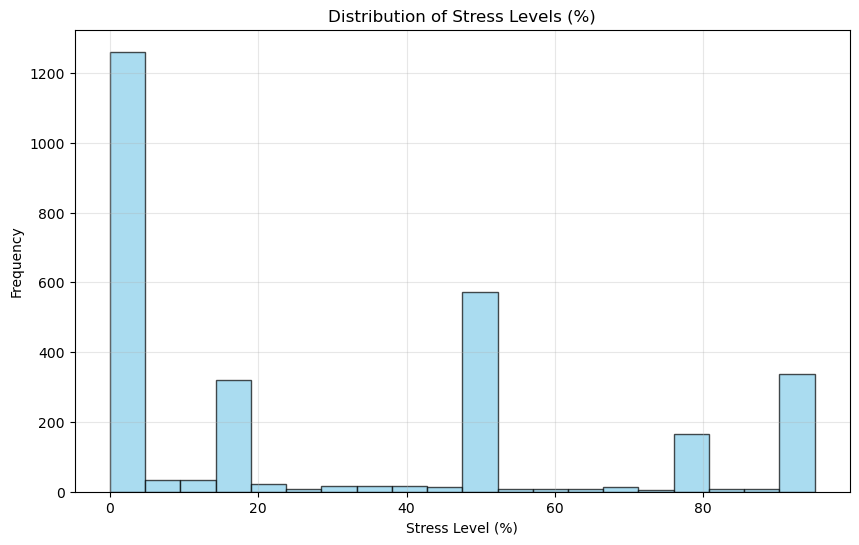

Processed data saved to X_features.npy and y_stress_levels.npy


In [6]:
# Process data for all subjects
print("Processing WESAD data...")
X_all = []
y_all = []

# List of subject folders (excluding S1 and S12 as they're not typically available)
subject_folders = ['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17']

for subject in subject_folders:
    try:
        print(f"Processing {subject}...")
        X, y = process_wesad_data_evs(subject, dataset_path)
        if len(X) > 0 and len(y) > 0:
            X_all.append(X)
            y_all.append(y)
            print(f"Processed {subject}: {X.shape} features, {y.shape} stress levels")
        else:
            print(f"No data processed for {subject}")
    except Exception as e:
        print(f"Error processing {subject}: {e}")

# Check if we have any data before combining
if len(X_all) > 0:
    # Combine all subject data
    X = np.vstack(X_all)
    y = np.hstack(y_all)

    print(f"\nFinal dataset shape: {X.shape}")
    print(f"Stress level statistics:")
    print(f"Min: {np.min(y):.2f}%")
    print(f"Max: {np.max(y):.2f}%")
    print(f"Mean: {np.mean(y):.2f}%")
    print(f"Std: {np.std(y):.2f}%")
    
    # Display distribution of stress levels
    plt.figure(figsize=(10, 6))
    plt.hist(y, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Distribution of Stress Levels (%)')
    plt.xlabel('Stress Level (%)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Save the processed data
    np.save('X_features.npy', X)
    np.save('y_stress_levels.npy', y)
    print("Processed data saved to X_features.npy and y_stress_levels.npy")
else:
    print("No data was processed. Please check the dataset structure.")

In [7]:
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Since we're doing regression (continuous stress levels), no need for class balancing
# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape for CNN (samples, timesteps, features)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_reshaped = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print(f"Reshaped training set: {X_train_reshaped.shape}")
print(f"Reshaped validation set: {X_val_reshaped.shape}")
print(f"Reshaped test set: {X_test_reshaped.shape}")

# Save the scaler for future use
joblib.dump(scaler, 'stress_scaler.pkl')
print("Feature scaler saved as 'stress_scaler.pkl'")

Training set: (1839, 29), (1839,)
Validation set: (460, 29), (460,)
Test set: (575, 29), (575,)
Reshaped training set: (1839, 29, 1)
Reshaped validation set: (460, 29, 1)
Reshaped test set: (575, 29, 1)
Feature scaler saved as 'stress_scaler.pkl'


In [12]:
# Improved CNN+LSTM hybrid model for Emotional Vitality Score
def create_evs_cnn_lstm_model(input_shape):
    """
    Hybrid CNN + LSTM model for Emotional Vitality Score prediction.
    CNN extracts local temporal features, LSTM captures temporal dependencies.
    Includes BatchNorm + Dropout for stability and regularization.
    """
    from tensorflow.keras.layers import BatchNormalization
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM, Dense
    from tensorflow.keras.optimizers import Adam
    import tensorflow as tf

    model = Sequential([
        # First convolutional block
        Conv1D(32, kernel_size=5, activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        # Second convolutional block
        Conv1D(64, kernel_size=5, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # Feed into single LSTM layer (simpler than stacked)
        LSTM(64, return_sequences=False),
        Dropout(0.3),

        # Fully connected dense layers
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(1, activation='linear')  # Regression output for EVS
    ])

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # slightly higher LR for small dataset
        loss='mse',
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )

    return model

# Create model
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
model = create_evs_cnn_lstm_model(input_shape)

# Summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_evs_cnn_lstm_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 29, 32)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 29, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 14, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 14, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,561 (197.50 KB)

 Trainable params: 50,177 (196.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [13]:
# Train the model
print("Starting model training...")
history = model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping, model_checkpoint, lr_reducer],
    verbose=1
)

Starting model training...
Epoch 1/100
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2102.1223 - mae: 31.0154 - rmse: 45.7909
Epoch 1: val_loss improved from inf to 2006.10693, saving model to best_evs_cnn_lstm_model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 2100.2583 - mae: 31.0120 - rmse: 45.7724 - val_loss: 2006.1069 - val_mae: 29.7383 - val_rmse: 44.7896 - learning_rate: 0.0010
Epoch 2/100
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1832.6617 - mae: 30.3997 - rmse: 42.8034
Epoch 2: val_loss improved from 2006.10693 to 1925.34741, saving model to best_evs_cnn_lstm_model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1833.4474 - mae: 30.4141 - rmse: 42.8128 - val_loss: 1925.3474 - val_mae: 29.3760 - val_rmse: 43.8788 - learning_rate: 0.0010
Epoch 3/100
54/58 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1740.6885 - mae: 30.2682 - rmse: 41.6940
Epoch 3: val_loss improved from 1925.34741 to 1690.62280, saving model to best_evs_cnn_lstm_model.keras
58/58 ━━━━━━━━━━━

In [14]:

# Load the best model
best_model = tf.keras.models.load_model('best_stress_cnn_lstm_model.keras')
print("Best model loaded successfully!")

# Evaluate the model on test data
print("\nEvaluating on test data...")
test_results = best_model.evaluate(X_test_reshaped, y_test, verbose=0)

# Display evaluation metrics
print(f"\nTest Results:")
print(f"Loss (MSE): {test_results[0]:.4f}")
print(f"MAE: {test_results[1]:.4f}")
print(f"RMSE: {test_results[2]:.4f}")

# Make predictions
y_pred = best_model.predict(X_test_reshaped).flatten()

# Calculate additional regression metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nAdditional Regression Metrics:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Best model loaded successfully!

Evaluating on test data...

Test Results:
Loss (MSE): 1512.8606
MAE: 26.7958
RMSE: 38.8955
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

Additional Regression Metrics:
MSE: 1512.8605
MAE: 26.7958
RMSE: 38.8955
R² Score: -0.3155


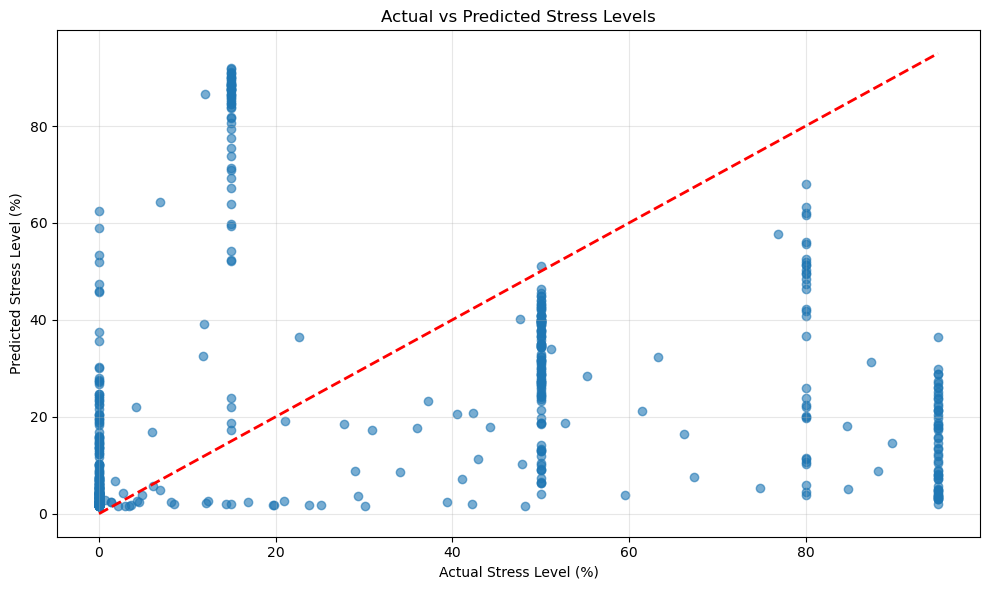

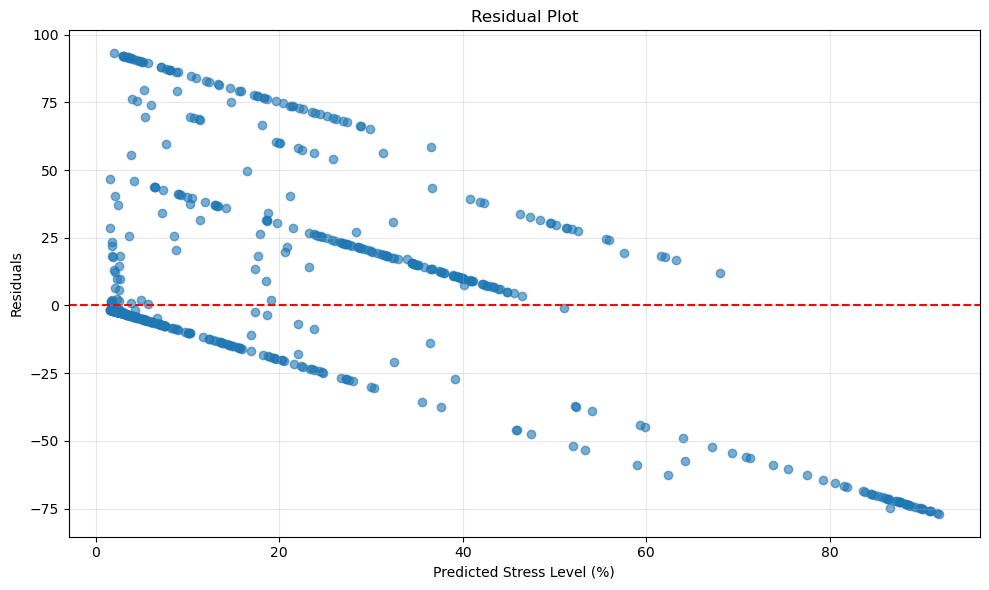

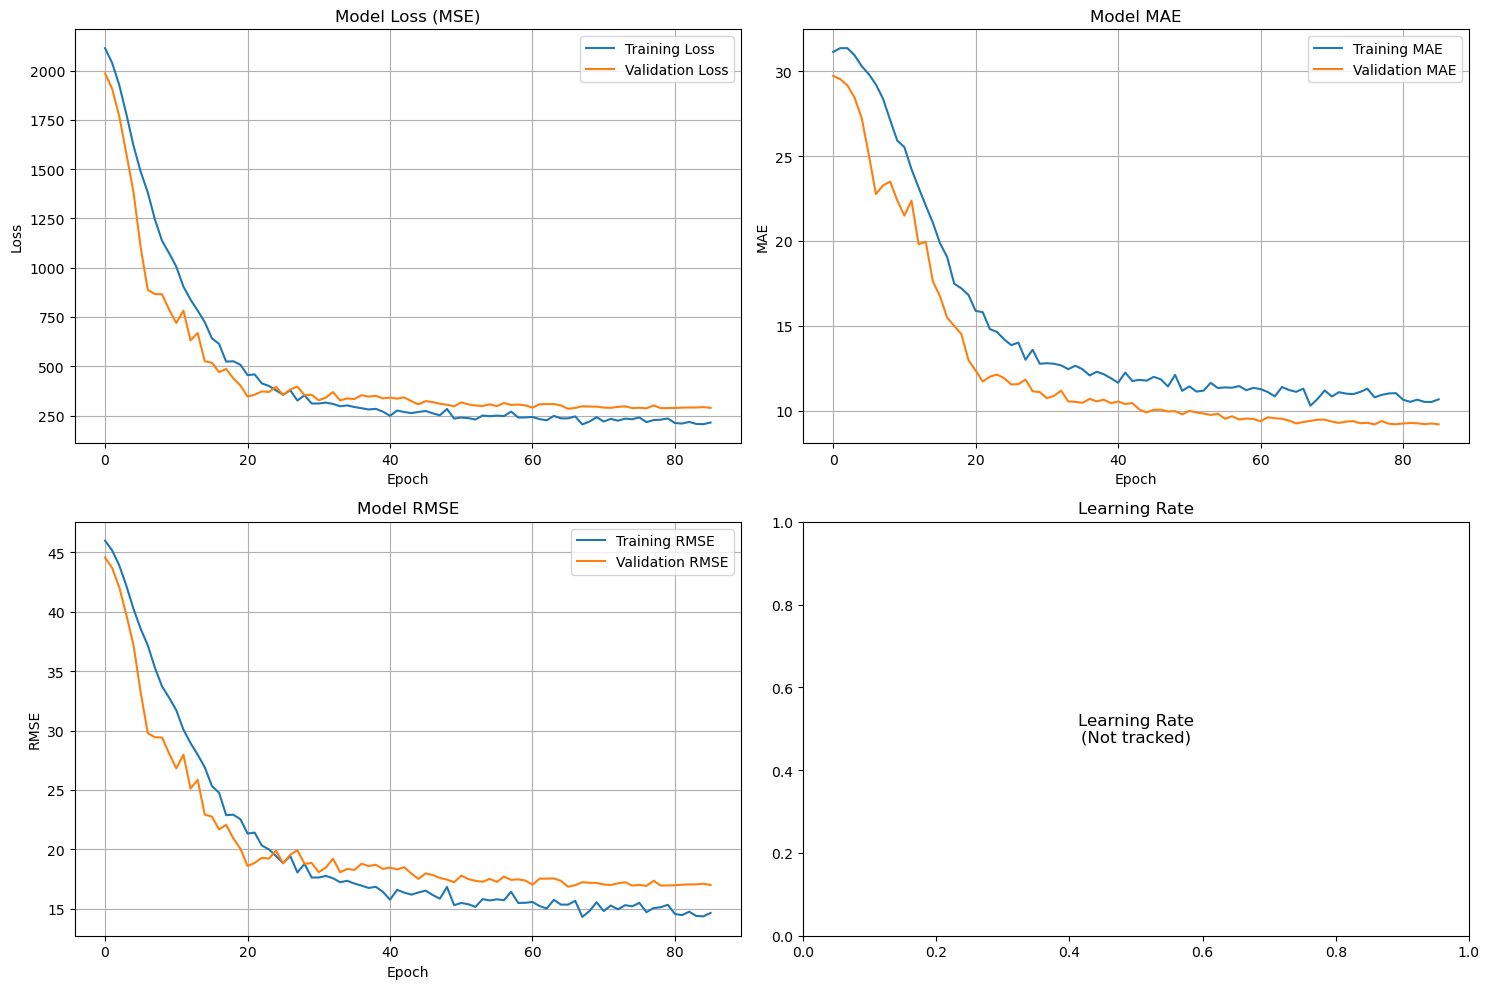

Final model saved as 'final_stress_model.keras'

STRESS LEVEL PREDICTION MODEL SUMMARY
Final Test MSE: 1512.8605
Final Test MAE: 26.7958%
Final Test RMSE: 38.8955%
Final Test R² Score: -0.3155


In [11]:
# Plot actual vs predicted stress levels
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Stress Level (%)')
plt.ylabel('Predicted Stress Level (%)')
plt.title('Actual vs Predicted Stress Levels')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('regression_plot.png')
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Stress Level (%)')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('residual_plot.png')
plt.show()

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss plot
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss (MSE)')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# MAE plot
axes[0, 1].plot(history.history['mae'], label='Training MAE')
axes[0, 1].plot(history.history['val_mae'], label='Validation MAE')
axes[0, 1].set_title('Model MAE')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()
axes[0, 1].grid(True)

# RMSE plot
axes[1, 0].plot(history.history['rmse'], label='Training RMSE')
axes[1, 0].plot(history.history['val_rmse'], label='Validation RMSE')
axes[1, 0].set_title('Model RMSE')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('RMSE')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Learning rate plot (if available)
if 'lr' in history.history:
    axes[1, 1].plot(history.history['lr'], label='Learning Rate')
    axes[1, 1].set_title('Learning Rate')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
else:
    axes[1, 1].text(0.5, 0.5, 'Learning Rate\n(Not tracked)', 
                   horizontalalignment='center', verticalalignment='center',
                   transform=axes[1, 1].transAxes, fontsize=12)
    axes[1, 1].set_title('Learning Rate')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Save the final model
best_model.save('final_stress_model.keras')
print("Final model saved as 'final_stress_model.keras'")

# Print model performance summary
print("\n" + "="*50)
print("STRESS LEVEL PREDICTION MODEL SUMMARY")
print("="*50)
print(f"Final Test MSE: {mse:.4f}")
print(f"Final Test MAE: {mae:.4f}%")
print(f"Final Test RMSE: {rmse:.4f}%")
print(f"Final Test R² Score: {r2:.4f}")
print("="*50)

In [20]:
import os
import joblib
import pickle

# Create a directory for your project files
project_dir = 'StressLevelProject'
if not os.path.exists(project_dir):
    os.makedirs(project_dir)
    print(f"Created directory: {project_dir}")

# Save the model
model_path = os.path.join(project_dir, 'stress_level_model.h5')
best_model.save(model_path)
print(f"Model saved as {model_path}")

# Save preprocessing scaler
scaler_path = os.path.join(project_dir, 'feature_scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"Feature scaler saved as {scaler_path}")

# Save training history
history_path = os.path.join(project_dir, 'training_history.pkl')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)
print(f"Training history saved as {history_path}")

# Save stress level information
stress_info_path = os.path.join(project_dir, 'stress_info.pkl')
stress_info = {
    'stress_range': '0-100%',
    'stress_categories': {
        'Low Stress (0-25%)': 'Meditation',
        'Medium-Low Stress (25-50%)': 'Neutral', 
        'Medium-High Stress (50-75%)': 'Amusement',
        'High Stress (75-100%)': 'Stress'
    },
    'min_stress': float(np.min(y)),
    'max_stress': float(np.max(y)),
    'mean_stress': float(np.mean(y))
}
with open(stress_info_path, 'wb') as f:
    pickle.dump(stress_info, f)
print(f"Stress level information saved as {stress_info_path}")

# Save model summary
summary_path = os.path.join(project_dir, 'model_summary.txt')
model_summary = {
    'input_shape': input_shape,
    'test_mse': f"{mse:.4f}",
    'test_mae': f"{mae:.4f}",
    'test_rmse': f"{rmse:.4f}",
    'test_r2': f"{r2:.4f}",
    'training_samples': len(X_train),
    'validation_samples': len(X_val),
    'test_samples': len(X_test),
    'feature_count': X_train.shape[1]
}

with open(summary_path, 'w') as f:
    f.write("STRESS LEVEL PREDICTION MODEL SUMMARY\n")
    f.write("=" * 50 + "\n\n")
    for key, value in model_summary.items():
        f.write(f"{key.replace('_', ' ').title()}: {value}\n")
print(f"Model summary saved as {summary_path}")

# Save evaluation metrics
metrics_path = os.path.join(project_dir, 'evaluation_metrics.txt')
with open(metrics_path, 'w') as f:
    f.write("MODEL EVALUATION METRICS\n")
    f.write("=" * 25 + "\n\n")
    f.write(f"MSE: {mse:.4f}\n")
    f.write(f"MAE: {mae:.4f}%\n")
    f.write(f"RMSE: {rmse:.4f}%\n")
    f.write(f"R² Score: {r2:.4f}\n")
print(f"Evaluation metrics saved as {metrics_path}")

print(f"\nAll files saved successfully to '{project_dir}' directory!")
print("\nFiles created:")
for file in os.listdir(project_dir):
    file_path = os.path.join(project_dir, file)
    if os.path.isfile(file_path):
        file_size = os.path.getsize(file_path)
        print(f"  {file} ({file_size} bytes)")

# Display absolute path to your files
print(f"\nAbsolute path to your project: {os.path.abspath(project_dir)}")

Created directory: StressLevelProject
Model saved as StressLevelProject\stress_level_model.h5
Feature scaler saved as StressLevelProject\feature_scaler.pkl
Training history saved as StressLevelProject\training_history.pkl
Stress level information saved as StressLevelProject\stress_info.pkl
Model summary saved as StressLevelProject\model_summary.txt
Evaluation metrics saved as StressLevelProject\evaluation_metrics.txt

All files saved successfully to 'StressLevelProject' directory!

Files created:
  evaluation_metrics.txt (120 bytes)
  feature_scaler.pkl (1295 bytes)
  model_summary.txt (278 bytes)
  stress_info.pkl (279 bytes)
  stress_level_model.h5 (2738496 bytes)
  training_history.pkl (5152 bytes)

Absolute path to your project: c:\Final Year\PROJECT\COGNITION\PREP\StressLevelProject
